<a href="https://colab.research.google.com/github/Arashi283/AIRepoOne/blob/main/DDoS_WithoutWidgets1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Please upload your CICDDoS2019 dataset zip (containing parquet files)


Saving archive (4).zip to archive (4) (5).zip
 Files extracted to: /content/cicddos2019_data
Found 17 parquet files.


📦 Combining parquet files: 100%|██████████| 17/17 [00:00<00:00, 36.66it/s]


 Combined dataset shape: (431371, 78)
 Numeric features retained: 78 columns

 Starting multi-iteration training...


100%|██████████| 10/10 [1:21:06<00:00, 486.60s/it]



 Best Accuracy: 99.9935%
Average Accuracy over runs: 88.7973%

 Classification Report:
                precision    recall  f1-score   support

       Benign       1.00      1.00      1.00     24458
    DrDoS_DNS       1.00      1.00      1.00       917
   DrDoS_LDAP       1.00      0.99      1.00       360
  DrDoS_MSSQL       1.00      1.00      1.00      1553
    DrDoS_NTP       1.00      1.00      1.00     30342
DrDoS_NetBIOS       1.00      0.97      0.99       149
   DrDoS_SNMP       1.00      1.00      1.00       679
    DrDoS_UDP       1.00      1.00      1.00      2605
         LDAP       1.00      1.00      1.00       477
        MSSQL       1.00      1.00      1.00      2131
      NetBIOS       0.99      0.99      0.99       161
      Portmap       0.99      1.00      1.00       171
          Syn       1.00      1.00      1.00     12343
         TFTP       1.00      1.00      1.00     24729
          UDP       1.00      1.00      1.00      4523
      UDP-lag       1.00      

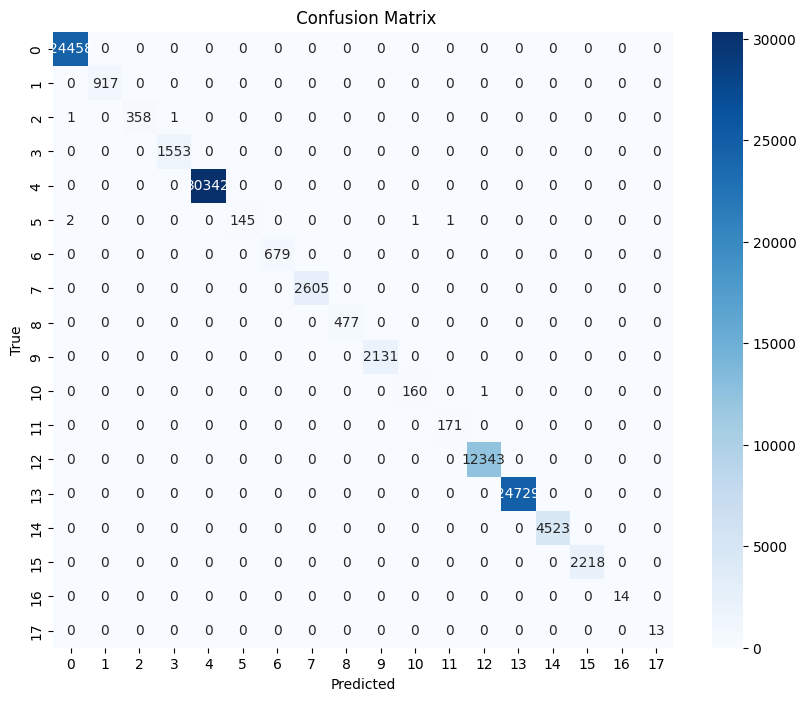

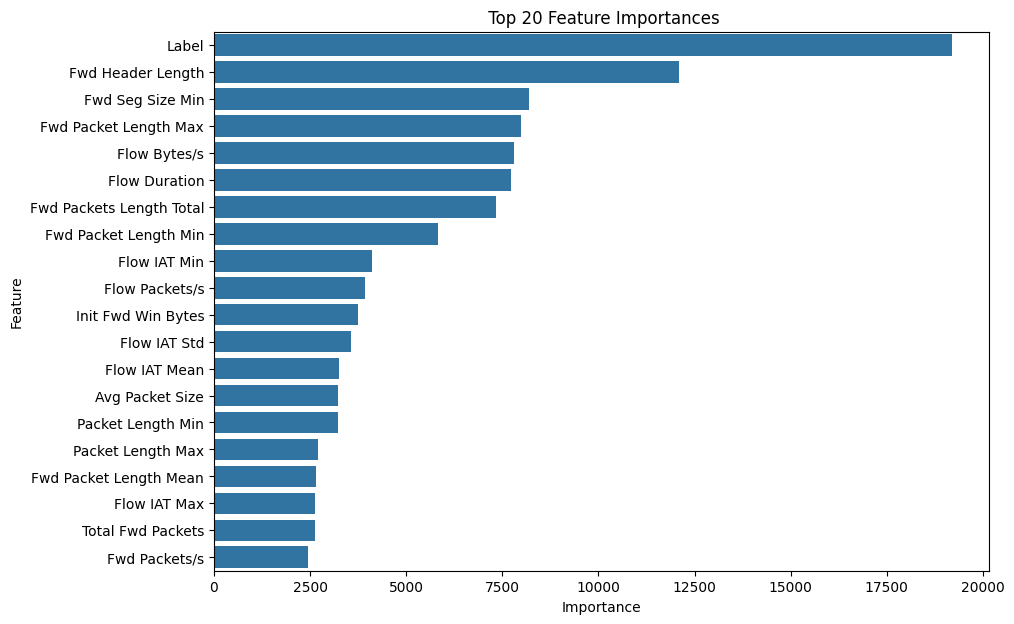

 Best model saved as best_ddos_model.pkl


In [ ]:
# ==========================================
#  CICDDoS2019 ML Training - Multi Iterations
# ==========================================
import pandas as pd
import numpy as np
import os
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from tqdm import tqdm
import joblib

# STEP 1️: Upload dataset zip/folder
print(" Please upload your CICDDoS2019 dataset zip (containing parquet files)")
uploaded = files.upload()

import zipfile
import io

zip_path = list(uploaded.keys())[0]
extract_path = "/content/cicddos2019_data"

with zipfile.ZipFile(io.BytesIO(uploaded[zip_path]), "r") as z:
    z.extractall(extract_path)

print(f" Files extracted to: {extract_path}")

# STEP 2️: Load and combine parquet files
all_files = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if f.endswith(".parquet")]
print(f"Found {len(all_files)} parquet files.")

df = pd.concat([pd.read_parquet(f) for f in tqdm(all_files, desc="📦 Combining parquet files")], ignore_index=True)
print(" Combined dataset shape:", df.shape)

# STEP 3️: Clean up data
df = df.dropna()
df = df.loc[:, ~df.columns.duplicated()]

# STEP 4️: Encode labels
if 'Label' not in df.columns:
    raise KeyError(" 'Label' column not found in dataset!")

le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

X = df.select_dtypes(include=[np.number])
y = df['Label']

print(f" Numeric features retained: {X.shape[1]} columns")

# STEP 5️: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# STEP 6️: Train multiple models with different seeds
best_acc = 0
best_model = None
accuracies = []

print("\n Starting multi-iteration training...")

for seed in tqdm(range(5, 51, 5)):  # 10 iterations: seeds 5,10,...,50
    model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=60,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_pred = y_pred

print(f"\n Best Accuracy: {best_acc * 100:.4f}%")
print(f"Average Accuracy over runs: {np.mean(accuracies) * 100:.4f}%")

# STEP 7️: Classification Report
print("\n Classification Report:\n", classification_report(y_test, best_pred, target_names=le.classes_))

# STEP 8️: Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, best_pred), annot=True, fmt='d', cmap='Blues')
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# STEP 9️: Feature Importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=importances.head(20), x='Importance', y='Feature')
plt.title(" Top 20 Feature Importances")
plt.show()

# STEP : Save the best model
joblib.dump(best_model, "best_ddos_model.pkl")
print(" Best model saved as best_ddos_model.pkl")
